In [ ]:
import os, signal, zipfile, random
import numpy as np
from google.colab import files
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!wget --no-check-certificate \
  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
  -O '/content/drive/MyDrive/Colab Notebooks/TSF/Resources/cats_and_dogs/cats_and_dogs_filtered.zip'

# !wget --no-check-certificate \
#     https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
#     -O '/content/drive/MyDrive/Colab Notebooks/TSF/Resources/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

--2021-01-17 03:19:23--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.115.128, 172.217.9.208, 172.253.63.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.115.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/content/drive/MyDrive/Colab Notebooks/TSF/Resources/cats_and_dogs/cats_and_dogs_filtered.zip’

/content/drive/MyDr 100%[===================>]  65.43M  78.0MB/s    in 0.8s    

2021-01-17 03:19:24 (78.0 MB/s) - ‘/content/drive/MyDrive/Colab Notebooks/TSF/Resources/cats_and_dogs/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [ ]:
local_zip = '/content/drive/MyDrive/Colab Notebooks/TSF/Resources/cats_and_dogs/cats_and_dogs_filtered.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/content/drive/MyDrive/Colab Notebooks/TSF/Resources/cats_and_dogs')
zip_ref.close()

In [ ]:
base_dir = '/content/drive/MyDrive/Colab Notebooks/TSF/Resources/cats_and_dogs/cats_and_dogs_filtered'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat/dog pictures
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat/dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')


In [ ]:
train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500


In [ ]:
nrows = 4
ncols = 4
pic_index = 0

In [ ]:
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[pic_index-8:pic_index]]
next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[pic_index-8:pic_index]]

for i, img_path in enumerate(next_cat_pix + next_dog_pix):
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off')
  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.3,
    height_shift_range=0.3,
    brightness_range=[0.8,1.2],
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (150, 150),
    batch_size = 20,
    class_mode = 'binary'
)

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = train_datagen.flow_from_directory(
    validation_dir,
    target_size = (150, 150),
    batch_size = 20,
    class_mode = 'binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
local_weights_file = '/content/drive/MyDrive/Colab Notebooks/TSF/Resources/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [ ]:
pre_trained_model = InceptionV3(
    input_shape = (150, 150, 3),
    weights = None,
    include_top = False
)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False
  if layer.name == 'mixed7':
    break

pre_trained_model.summary()

In [ ]:
last_layer = pre_trained_model.get_layer("mixed10")
last_output = last_layer.output

In [ ]:
x = layers.Flatten()(last_output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1, activation='sigmoid')(x)

In [ ]:
model = Model(pre_trained_model.input, x)

In [ ]:
model.summary()

In [ ]:
class StopOnAccuracy(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.995):
      print("\nReached 99.5% accuracy so cancelling training!")
      self.model.stop_training = True

stop = StopOnAccuracy()

In [ ]:
starting_lr = 1e-4

lr_epochs = 10

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: starting_lr * 10 ** (2 * (epoch / lr_epochs)))

In [ ]:
model.compile(
    loss = 'binary_crossentropy',
    optimizer = tf.keras.optimizers.RMSprop(lr=starting_lr),
    metrics = ['accuracy']
)

In [ ]:
lr_history = model.fit(
    train_generator,
    steps_per_epoch = 100,
    epochs = lr_epochs,
    callbacks = [lr_schedule]
)

Epoch 1/10
100/100 [==============================] - 26s 207ms/step - loss: 0.6568 - accuracy: 0.9265
Epoch 2/10
100/100 [==============================] - 21s 206ms/step - loss: 0.2589 - accuracy: 0.9268
Epoch 3/10
100/100 [==============================] - 20s 205ms/step - loss: 0.2152 - accuracy: 0.9320
Epoch 4/10
100/100 [==============================] - 21s 205ms/step - loss: 0.2057 - accuracy: 0.9310
Epoch 5/10
100/100 [==============================] - 21s 205ms/step - loss: 0.2396 - accuracy: 0.9305
Epoch 6/10
100/100 [==============================] - 21s 206ms/step - loss: 0.1877 - accuracy: 0.9292
Epoch 7/10
100/100 [==============================] - 21s 206ms/step - loss: 0.1629 - accuracy: 0.9341
Epoch 8/10
100/100 [==============================] - 21s 205ms/step - loss: 0.1713 - accuracy: 0.9279
Epoch 9/10
100/100 [==============================] - 21s 206ms/step - loss: 0.2121 - accuracy: 0.9243
Epoch 10/10
100/100 [==============================] - 20s 205ms/step - l

(0.0001, 0.01, 0.0, 0.6)

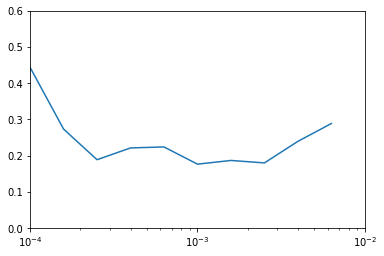

In [ ]:
lrs = starting_lr * (10 ** (2 * np.arange(lr_epochs) / lr_epochs))
plt.semilogx(lrs, lr_history.history["loss"])
plt.axis([starting_lr, starting_lr * (10 ** 2), 0, 0.6])

In [ ]:
model = Model(pre_trained_model.input, x)

model.compile(
    loss = 'binary_crossentropy',
    optimizer = tf.keras.optimizers.RMSprop(lr=0.001),
    metrics = ['accuracy']
)

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch = 100,
    epochs = 10,
    validation_data = validation_generator,
    validation_steps = 50
)

model.save('/content/drive/MyDrive/Colab Notebooks/TSF/Models/cat_dog_model_30')

Epoch 1/10
100/100 [==============================] - 30s 300ms/step - loss: 0.1566 - accuracy: 0.9450 - val_loss: 0.2710 - val_accuracy: 0.9240
Epoch 2/10
100/100 [==============================] - 30s 299ms/step - loss: 0.1463 - accuracy: 0.9515 - val_loss: 0.1658 - val_accuracy: 0.9330
Epoch 3/10
100/100 [==============================] - 30s 298ms/step - loss: 0.1427 - accuracy: 0.9530 - val_loss: 0.2763 - val_accuracy: 0.9160
Epoch 4/10
100/100 [==============================] - 30s 298ms/step - loss: 0.1445 - accuracy: 0.9535 - val_loss: 0.2750 - val_accuracy: 0.9360
Epoch 5/10
100/100 [==============================] - 30s 297ms/step - loss: 0.1374 - accuracy: 0.9530 - val_loss: 0.1584 - val_accuracy: 0.9410
Epoch 6/10
100/100 [==============================] - 30s 300ms/step - loss: 0.1280 - accuracy: 0.9565 - val_loss: 0.2409 - val_accuracy: 0.9300
Epoch 7/10
100/100 [==============================] - 30s 297ms/step - loss: 0.1411 - accuracy: 0.9555 - val_loss: 0.1870 - val_ac

Text(0.5, 1.0, 'Training and validation loss')

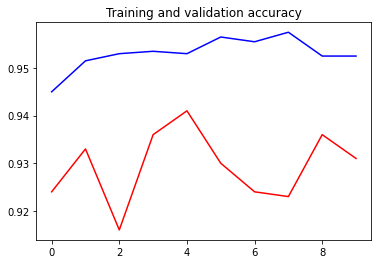

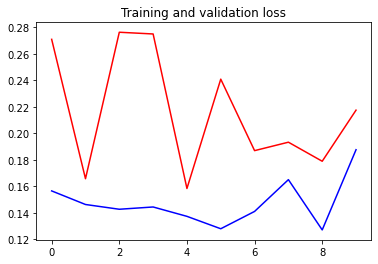

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b')
plt.plot(epochs, val_acc, 'r')
plt.title ('Training and validation accuracy')
plt.figure()

plt.plot(epochs, loss, 'b')
plt.plot(epochs, val_loss, 'r')
plt.title('Training and validation loss')

In [ ]:
model =  tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/TSF/Models/cat_dog_model_20')

In [ ]:
uploaded = files.upload()

for fn in uploaded.keys():
 
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")

Saving 5544.jpg to 5544.jpg
Saving kitten-440379.jpg to kitten-440379.jpg
Saving Thinking-of-getting-a-cat.png to Thinking-of-getting-a-cat.png
[1.]
5544.jpg is a dog
[1.]
kitten-440379.jpg is a dog
[1.]
Thinking-of-getting-a-cat.png is a dog


In [ ]:
# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)
# Let's prepare a random input image from the training set.
cat_img_files = [os.path.join(train_cats_dir, f) for f in train_cat_fnames]
dog_img_files = [os.path.join(train_dogs_dir, f) for f in train_dog_fnames]
img_path = random.choice(cat_img_files + dog_img_files)

img = load_img(img_path, target_size=(150, 150))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map
    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      # Postprocess the feature to make it visually palatable
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # We'll tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

KeyboardInterrupt: ignored